SMOTE & XGBoost

In [2]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
#check if seaborn is installed

import subprocess

try:
    subprocess.check_call(['pip', 'show', 'seaborn'])
except subprocess.CalledProcessError:
    # Seaborn is not installed
    %pip install seaborn
else:
    print('Seaborn is already installed.')

Seaborn is already installed.


In [4]:
#check if plotly is installed

import subprocess

try:
    subprocess.check_call(['pip', 'show', 'plotly'])
except subprocess.CalledProcessError:
    # plotly is not installed
    %pip install plotly
else:
    print('plotly is already installed.')



plotly is already installed.


In [5]:
#check if xgboost is installed

import subprocess

try:
    subprocess.check_call(['pip', 'show', 'xgboost'])
except subprocess.CalledProcessError:
    # xgboost is not installed
    %pip install xgboost
else:
    print('xgboost is already installed.')

xgboost is already installed.


In [6]:
# import necessary libraries

import pandas as pd
import numpy as np
import xgboost as xgb
import datetime


from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
import matplotlib.gridspec as gridspec # to do the grid of plots


# Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [7]:
# importing openpyxl module
import openpyxl

# input excel file path
inputExcelFile ="MorpaData.xlsx"

# creating or loading an excel workbook
newWorkbook = openpyxl.load_workbook(inputExcelFile)

# printing all the sheetnames in an excel file using sheetnames attribute
print('The Sheet names of the given excel file: ')

# Getting the sheetnames as a list using the sheetnames attribute
sheetNames=newWorkbook.sheetnames

# Traversing in the sheetNames list
for name in sheetNames:
   print(name)

The Sheet names of the given excel file: 
Üye Listesi
Giriş Logları
Oyun
Konu anlatımı
çalışmalar
Sınav
konu


In [8]:
# get the member data from excel

member_df = pd.read_excel('MorpaData.xlsx',sheet_name='Üye Listesi')
print(member_df.head(10),'\n\n')

print(member_df.info())

# get the unique number of members

print(member_df['Üye'].nunique())

       Üye  Şehir    İlçe       Okul  Sınıf
0  2070306  10826  162678  120166963      4
1  2910824  16378  624995  813905547      6
2  3045726  10989  721319  231052437      4
3  3661377  10185  376777  733057858      8
4  3794510  11631  709268   72006202      4
5  3969040  11631  626646  305454095      5
6  5084112  11631   23819  659915466      8
7  6789503  15012  248394  310622551      3
8  7221591  11631  485022  529623633      3
9  7899454  14951  599378  265076040      8 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Üye     1999 non-null   int64
 1   Şehir   1999 non-null   int64
 2   İlçe    1999 non-null   int64
 3   Okul    1999 non-null   int64
 4   Sınıf   1999 non-null   int64
dtypes: int64(5)
memory usage: 78.2 KB
None
1999


In [9]:
# get the Login logs data from excel

login_df = pd.read_excel('MorpaData.xlsx',sheet_name='Giriş Logları')
login_df['Giriş Zamanı'] = pd.to_datetime(login_df['Giriş Zamanı'], format='%d/%m/%Y %H:%M:%S')
login_df['Çıkış Zamanı'] = pd.to_datetime(login_df['Çıkış Zamanı'], format='%d/%m/%Y %H:%M:%S')
print(login_df.head(10),'\n\n')

print(login_df.info(),'\n\n')


# get the unique number of members on login data
print("unique member count on login data: ",login_df['Üye'].nunique())

   GirişID      Üye            Giriş Zamanı            Çıkış Zamanı  \
0   181915  2070306 2021-09-09 20:54:37.683 2021-09-09 21:46:55.070   
1   128004  2910824 2021-09-07 20:33:32.583 2021-09-07 21:25:53.753   
2   178974  2910824 2021-09-09 20:18:36.960 2021-09-09 20:58:58.370   
3   182887  2910824 2021-09-09 21:10:33.563 2021-09-09 22:04:55.467   
4   238434  2910824 2021-09-12 10:59:55.210 2021-09-12 11:04:15.233   
5   244552  2910824 2021-09-12 12:32:28.067 2021-09-12 13:28:49.353   
6   273273  2910824 2021-09-13 13:25:51.117 2021-09-13 13:58:05.470   
7   273943  2910824 2021-09-13 13:58:05.470 2021-09-13 14:36:48.393   
8   285795  2910824 2021-09-13 18:44:16.997 2021-09-13 19:44:59.743   
9   345946  2910824 2021-09-15 17:06:06.027 2021-09-15 17:51:50.893   

   Süre Dakika  
0           52  
1           52  
2           40  
3           54  
4            5  
5           56  
6           33  
7           38  
8           60  
9           45   


<class 'pandas.core.frame.Da

In [10]:
# get the lecturing logs data from excel

lecturing_df = pd.read_excel('MorpaData.xlsx',sheet_name='Konu anlatımı')
lecturing_df['Giriş Zamanı'] = pd.to_datetime(lecturing_df['Giriş Zamanı'], format='%d/%m/%Y %H:%M:%S')
lecturing_df['Çıkış Zamanı'] = pd.to_datetime(lecturing_df['Çıkış Zamanı'], format='%d/%m/%Y %H:%M:%S')

# calculate the duration of the lecturing

lecturing_df['lec_Süre'] = (lecturing_df['Çıkış Zamanı'] - lecturing_df['Giriş Zamanı']).dt.total_seconds().astype(int)

print(lecturing_df.head(10),'\n\n')

print(lecturing_df.info(),'\n\n')


# get the unique number of members on lecturing data
print("Unique number of users on lecturing: ", lecturing_df['Üye'].nunique())

       Üye  Eğitim Materyali  Eğitim Materyali Türü  Ders   Konu  \
0  2070306      518826088921                      2     2   9864   
1  2070306      608022794749                      2     2   9864   
2  2910824      633794085515                      2     2   8964   
3  2910824      787304215519                      2     9   9535   
4  2910824      137540475371                      2     3   9659   
5  2910824      799934114128                      2    11   4421   
6  2910824      139874336279                      2     1  10002   
7  2910824      884070756143                      2     2   8965   
8  2910824      884070756143                      2     2   8965   
9  2910824      139874336279                      2     1  10002   

   Katılım Oranı  Performans            Giriş Zamanı            Çıkış Zamanı  \
0             75           0 2021-09-09 20:55:06.357 2021-09-09 21:00:04.783   
1            100           0 2021-09-09 21:00:04.797 2021-09-09 21:46:55.070   
2          

In [11]:
# get the member studies data from excel

studies_df = pd.read_excel('MorpaData.xlsx',sheet_name='çalışmalar')
studies_df['Giriş Zamanı'] = pd.to_datetime(studies_df['Giriş Zamanı'], format='%d/%m/%Y %H:%M:%S')
studies_df['Çıkış Zamanı'] = pd.to_datetime(studies_df['Çıkış Zamanı'], format='%d/%m/%Y %H:%M:%S')

studies_df['stud_Süre'] = (studies_df['Çıkış Zamanı'] - studies_df['Giriş Zamanı']).dt.total_seconds().astype(int)

print(studies_df.head(10),'\n\n')

print(studies_df.info(),'\n\n')

# get the unique number of members on studies data
print("unique member count on studies data: ",studies_df['Üye'].nunique())

       Üye  Eğitim Materyali  Eğitim Materyali Türü  Ders   Konu  \
0  2910824      291765069973                      3     2   8964   
1  2910824      383712317425                      3     9   9535   
2  2910824      291765069973                      3     2   8964   
3  2910824      450320146095                      3     3   9659   
4  2910824      460263704270                      3    11   4421   
5  2910824      170232354529                      3     2   8965   
6  2910824      343498413848                      3     1  10002   
7  2910824      924340585642                      3     2   8966   
8  2910824      990590760357                      3     3   9661   
9  2910824       90390416811                      3     2   8971   

   Katılım Oranı  Performans            Giriş Zamanı            Çıkış Zamanı  \
0            100          62 2021-09-07 20:34:09.977 2021-09-07 20:37:27.890   
1            100          90 2021-09-09 21:18:02.070 2021-09-09 22:04:55.470   
2          

In [12]:
# get the member exams data from excel

exams_df = pd.read_excel('MorpaData.xlsx',sheet_name='Sınav')
exams_df['Giriş Zamanı'] = exams_df['Giriş Zamanı'].apply(lambda x: x.strftime("%d/%m/%Y  %H:%M:%S"))
exams_df['Çıkış Zamanı'] = exams_df['Çıkış Zamanı'].apply(lambda x: x.strftime("%d/%m/%Y  %H:%M:%S"))

exams_df['Giriş Zamanı'] = pd.to_datetime(exams_df['Giriş Zamanı'], format='%d/%m/%Y %H:%M:%S')
exams_df['Çıkış Zamanı'] = pd.to_datetime(exams_df['Çıkış Zamanı'], format='%d/%m/%Y %H:%M:%S')

exams_df['Giriş Zamanı']

print(exams_df.head(10),'\n\n')

print(exams_df.info(),'\n\n')

# get the unique number of members on exams data
print("unique member count on exams data: ",exams_df['Üye'].nunique())


# wrong answers are not deducted from the total score.

       Üye         Sınav   Konu  Sınav Türü  Doğru Sayısı  Yanlış Sayısı  \
0  2910824  268222943622   8964           1             8              1   
1  2910824  501151045356   9535           1             9              0   
2  2910824  934072969211   9659           1             8              2   
3  2910824  934072969211   9659           1             9              1   
4  2910824     438484723   4421           1             4              6   
5  2910824  523324425042   8965           1             0              8   
6  2910824  182157124583  10002           1             0              0   
7  2910824  182157124583  10002           1             5              5   
8  2910824  636098373206   8971           1             9              0   
9  2910824  808509304221   9662           1             3              6   

   Boş Sayısı  Puan        Giriş Zamanı        Çıkış Zamanı  Süre  GirişLog  
0           1    80 2021-09-07 20:40:54 2021-09-07 20:45:06   237    128004  
1      

In [13]:
# get the member subject data from excel

subject_df = pd.read_excel('MorpaData.xlsx',sheet_name='konu')
subject_df.head(10)

#sort according to aktif materyal sayısı

subject_df.sort_values(by=['Aktif Materyal Sayısı'],ascending=False)



,Sınıf,Ders,Konu,Aktif Materyal Sayısı,Toplam Materyal Sayısı
4499,25,2,899,58,58
4110,22,1,7699,42,49
5324,36,3,6749,39,39
3916,20,3,2192,38,39
4728,27,3,4338,37,37
...,...,...,...,...,...
4794,28,2,4585,0,1
4795,28,2,4586,0,1
4796,28,2,4587,0,1
872,4,2,9870,0,3


In [14]:
#left join the exam and subject dataframes

exam_subject_df = pd.merge(exams_df,subject_df,how='left',left_on='Konu',right_on='Konu')

# change column names for further join operations
exam_subject_df.rename(
    columns={"Giriş Zamanı": "S_Giriş Zamanı", "Çıkış Zamanı": "S_Çıkış Zamanı", "Süre":"S_süre"},
    inplace=True,
)


In [15]:
# drop non-numeric sınıf rows

exam_subject_df = exam_subject_df[exam_subject_df['Sınıf'].notna()]

exam_subject_df

,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı
0,2910824,268222943622,8964,1,8,1,1,80,2021-09-07 20:40:54,2021-09-07 20:45:06,237,128004,6.0,2.0,6.0,6.0
1,2910824,501151045356,9535,1,9,0,1,90,2021-09-09 21:20:08,2021-09-09 21:24:25,241,182887,6.0,9.0,6.0,6.0
2,2910824,934072969211,9659,1,8,2,0,80,2021-09-12 11:03:55,2021-09-12 12:48:24,149,238434,6.0,3.0,6.0,6.0
3,2910824,934072969211,9659,1,9,1,0,90,2021-09-13 14:03:34,2021-09-13 14:14:50,659,273943,6.0,3.0,6.0,6.0
4,2910824,438484723,4421,1,4,6,0,40,2021-09-13 18:53:41,2021-10-07 19:32:12,115,285795,6.0,11.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8308,2428472503,45103129645,8271,1,4,1,0,80,2021-09-29 07:09:59,2021-09-29 07:14:40,254,827926,2.0,4.0,6.0,7.0
8309,2428472503,45103129645,8271,1,5,0,0,100,2021-09-29 07:14:31,2021-09-29 07:15:17,19,827926,2.0,4.0,6.0,7.0
8310,2428472503,590286074810,9839,1,5,0,0,100,2021-09-29 07:15:10,2021-09-29 07:20:16,143,827926,2.0,4.0,6.0,6.0
8311,2428472503,120928860188,8892,1,10,0,0,100,2021-09-29 18:55:21,2021-09-29 18:56:32,45,850540,2.0,2.0,6.0,6.0


In [16]:
exam_subject_df['Sınıf'] = exam_subject_df['Sınıf'].astype('int64')
exam_subject_df['Ders'] = exam_subject_df['Ders'].astype('int64')
exam_subject_df['Aktif Materyal Sayısı'] = exam_subject_df['Aktif Materyal Sayısı'].astype('int64')
exam_subject_df['Toplam Materyal Sayısı'] = exam_subject_df['Toplam Materyal Sayısı'].astype('int64')

exam_subject_df.head(10)

,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı
0,2910824,268222943622,8964,1,8,1,1,80,2021-09-07 20:40:54,2021-09-07 20:45:06,237,128004,6,2,6,6
1,2910824,501151045356,9535,1,9,0,1,90,2021-09-09 21:20:08,2021-09-09 21:24:25,241,182887,6,9,6,6
2,2910824,934072969211,9659,1,8,2,0,80,2021-09-12 11:03:55,2021-09-12 12:48:24,149,238434,6,3,6,6
3,2910824,934072969211,9659,1,9,1,0,90,2021-09-13 14:03:34,2021-09-13 14:14:50,659,273943,6,3,6,6
4,2910824,438484723,4421,1,4,6,0,40,2021-09-13 18:53:41,2021-10-07 19:32:12,115,285795,6,11,5,7
5,2910824,523324425042,8965,1,0,8,2,0,2021-09-15 18:09:04,2021-09-15 18:17:35,492,349321,6,2,6,6
6,2910824,182157124583,10002,1,0,0,10,0,2021-09-17 18:27:05,2021-09-17 18:27:30,5,414086,6,1,3,3
7,2910824,182157124583,10002,1,5,5,0,50,2021-09-17 18:27:23,2021-09-17 18:28:56,73,414086,6,1,3,3
8,2910824,636098373206,8971,1,9,0,1,90,2021-09-22 20:45:43,2021-09-28 19:29:37,588,598986,6,2,6,6
9,2910824,808509304221,9662,1,3,6,1,30,2021-09-23 20:31:26,2021-09-23 20:34:46,176,639881,6,3,7,7


In [17]:
# add cumulative lecture time to exam_subject dataframe for each member according to the subject prior to exam date s_Giriş Zamanı

# calculate cumulative lecture time before the exam date for each member of each subject
exam_subject_df['cum_lecture_time'] = 0
for index, row in exam_subject_df.iterrows():
    df = lecturing_df[lecturing_df['Üye'] == row['Üye']]
    df = df[df['Konu'] == row['Konu']]
    df = df[df['Giriş Zamanı'] < row['S_Giriş Zamanı']]
    df['lec_Süre'] = df['lec_Süre'].astype('int64')
    exam_subject_df.at[index,'cum_lecture_time'] = df['lec_Süre'].sum()

# calculate cumulative study time before the exam date for each member of each subject
exam_subject_df['cum_study_time'] = 0
for index, row in exam_subject_df.iterrows():
    df = studies_df[studies_df['Üye'] == row['Üye']]
    df = df[df['Konu'] == row['Konu']]
    df = df[df['Giriş Zamanı'] < row['S_Giriş Zamanı']]
    df['stud_Süre'] = df['stud_Süre'].astype('int64')
    exam_subject_df.at[index,'cum_study_time'] = df['stud_Süre'].sum()

exam_subject_df['total_study_time'] = exam_subject_df['cum_lecture_time'] + exam_subject_df['cum_study_time']
        
exam_subject_df



,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı,cum_lecture_time,cum_study_time,total_study_time
0,2910824,268222943622,8964,1,8,1,1,80,2021-09-07 20:40:54,2021-09-07 20:45:06,237,128004,6,2,6,6,2905,197,3102
1,2910824,501151045356,9535,1,9,0,1,90,2021-09-09 21:20:08,2021-09-09 21:24:25,241,182887,6,9,6,6,432,2813,3245
2,2910824,934072969211,9659,1,8,2,0,80,2021-09-12 11:03:55,2021-09-12 12:48:24,149,238434,6,3,6,6,0,0,0
3,2910824,934072969211,9659,1,9,1,0,90,2021-09-13 14:03:34,2021-09-13 14:14:50,659,273943,6,3,6,6,591,2774,3365
4,2910824,438484723,4421,1,4,6,0,40,2021-09-13 18:53:41,2021-10-07 19:32:12,115,285795,6,11,5,7,438,3134,3572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8308,2428472503,45103129645,8271,1,4,1,0,80,2021-09-29 07:09:59,2021-09-29 07:14:40,254,827926,2,4,6,7,0,0,0
8309,2428472503,45103129645,8271,1,5,0,0,100,2021-09-29 07:14:31,2021-09-29 07:15:17,19,827926,2,4,6,7,0,0,0
8310,2428472503,590286074810,9839,1,5,0,0,100,2021-09-29 07:15:10,2021-09-29 07:20:16,143,827926,2,4,6,6,0,0,0
8311,2428472503,120928860188,8892,1,10,0,0,100,2021-09-29 18:55:21,2021-09-29 18:56:32,45,850540,2,2,6,6,0,0,0


In [18]:
# to tag the members who attempt gaming the system, I crate a deep copy of exams_df to exams_df_gtsLabeled.

exams_df_gtsLabeled = exam_subject_df.copy(deep=True)

# create a new column for labeling and overlapping time

exams_df_gtsLabeled['Label'] = ""
exams_df_gtsLabeled['Overlap (secs.)'] = ""

# update the index of exams_df_gtsLabeled

exams_df_gtsLabeled.reset_index(drop=True, inplace=True)

# then we write the conditions for labeling the data who "Gaming the System". 1 for gaming, 0 for not gaming.

for i in range(1,len(exams_df_gtsLabeled)):
    if exams_df_gtsLabeled['Üye'][i-1] == exams_df_gtsLabeled['Üye'][i]:
        if exams_df_gtsLabeled['Sınav'][i-1] == exams_df_gtsLabeled['Sınav'][i]:
            if exams_df_gtsLabeled['Konu'][i-1] == exams_df_gtsLabeled['Konu'][i]:
                if (exams_df_gtsLabeled['S_Çıkış Zamanı'][i-1] > exams_df_gtsLabeled['S_Giriş Zamanı'][i]) and (exams_df_gtsLabeled['Puan'][i-1] < exams_df_gtsLabeled['Puan'][i]) and (exams_df_gtsLabeled['GirişLog'][i-1] == exams_df_gtsLabeled['GirişLog'][i]):
                    exams_df_gtsLabeled['Label'][i] = 1
                    exams_df_gtsLabeled['Overlap (secs.)'][i] = (exams_df_gtsLabeled['S_Giriş Zamanı'][i] - exams_df_gtsLabeled['S_Çıkış Zamanı'][i-1]).total_seconds() * -1  # this is the overlapping time in seconds 

exams_df_gtsLabeled

C:\Users\melih\AppData\Local\Temp\ipykernel_20968\2612624138.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_df_gtsLabeled['Label'][i] = 1
C:\Users\melih\AppData\Local\Temp\ipykernel_20968\2612624138.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_df_gtsLabeled['Overlap (secs.)'][i] = (exams_df_gtsLabeled['S_Giriş Zamanı'][i] - exams_df_gtsLabeled['S_Çıkış Zamanı'][i-1]).total_seconds() * -1  # this is the overlapping time in seconds


,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı,cum_lecture_time,cum_study_time,total_study_time,Label,Overlap (secs.)
0,2910824,268222943622,8964,1,8,1,1,80,2021-09-07 20:40:54,2021-09-07 20:45:06,237,128004,6,2,6,6,2905,197,3102,,
1,2910824,501151045356,9535,1,9,0,1,90,2021-09-09 21:20:08,2021-09-09 21:24:25,241,182887,6,9,6,6,432,2813,3245,,
2,2910824,934072969211,9659,1,8,2,0,80,2021-09-12 11:03:55,2021-09-12 12:48:24,149,238434,6,3,6,6,0,0,0,,
3,2910824,934072969211,9659,1,9,1,0,90,2021-09-13 14:03:34,2021-09-13 14:14:50,659,273943,6,3,6,6,591,2774,3365,,
4,2910824,438484723,4421,1,4,6,0,40,2021-09-13 18:53:41,2021-10-07 19:32:12,115,285795,6,11,5,7,438,3134,3572,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,2428472503,45103129645,8271,1,4,1,0,80,2021-09-29 07:09:59,2021-09-29 07:14:40,254,827926,2,4,6,7,0,0,0,,
7874,2428472503,45103129645,8271,1,5,0,0,100,2021-09-29 07:14:31,2021-09-29 07:15:17,19,827926,2,4,6,7,0,0,0,1,9.0
7875,2428472503,590286074810,9839,1,5,0,0,100,2021-09-29 07:15:10,2021-09-29 07:20:16,143,827926,2,4,6,6,0,0,0,,
7876,2428472503,120928860188,8892,1,10,0,0,100,2021-09-29 18:55:21,2021-09-29 18:56:32,45,850540,2,2,6,6,0,0,0,,


In [19]:
#Sort the tagged data according to the member and subject

exams_df_gtsLabeled.sort_values(by=['Konu','Üye'])

# name the table as df for the sake of simplicity

df = exams_df_gtsLabeled

df

,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı,cum_lecture_time,cum_study_time,total_study_time,Label,Overlap (secs.)
0,2910824,268222943622,8964,1,8,1,1,80,2021-09-07 20:40:54,2021-09-07 20:45:06,237,128004,6,2,6,6,2905,197,3102,,
1,2910824,501151045356,9535,1,9,0,1,90,2021-09-09 21:20:08,2021-09-09 21:24:25,241,182887,6,9,6,6,432,2813,3245,,
2,2910824,934072969211,9659,1,8,2,0,80,2021-09-12 11:03:55,2021-09-12 12:48:24,149,238434,6,3,6,6,0,0,0,,
3,2910824,934072969211,9659,1,9,1,0,90,2021-09-13 14:03:34,2021-09-13 14:14:50,659,273943,6,3,6,6,591,2774,3365,,
4,2910824,438484723,4421,1,4,6,0,40,2021-09-13 18:53:41,2021-10-07 19:32:12,115,285795,6,11,5,7,438,3134,3572,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,2428472503,45103129645,8271,1,4,1,0,80,2021-09-29 07:09:59,2021-09-29 07:14:40,254,827926,2,4,6,7,0,0,0,,
7874,2428472503,45103129645,8271,1,5,0,0,100,2021-09-29 07:14:31,2021-09-29 07:15:17,19,827926,2,4,6,7,0,0,0,1,9.0
7875,2428472503,590286074810,9839,1,5,0,0,100,2021-09-29 07:15:10,2021-09-29 07:20:16,143,827926,2,4,6,6,0,0,0,,
7876,2428472503,120928860188,8892,1,10,0,0,100,2021-09-29 18:55:21,2021-09-29 18:56:32,45,850540,2,2,6,6,0,0,0,,


In [20]:
df['Label'].value_counts()

# we have 7878 rows data and 290 of them are labeled as 1. This means that 290 members attempted gaming the system.


     7588
1     290
Name: Label, dtype: int64

In [21]:
# get the gaming the system data

df.loc[df['Label'] == 1]

,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı,cum_lecture_time,cum_study_time,total_study_time,Label,Overlap (secs.)
7,2910824,182157124583,10002,1,5,5,0,50,2021-09-17 18:27:23,2021-09-17 18:28:56,73,414086,6,1,3,3,268,2699,2967,1,7.0
10,2910824,808509304221,9662,1,5,3,2,50,2021-09-23 20:34:34,2021-09-23 20:36:56,119,639881,6,3,7,7,0,988,988,1,12.0
12,2910824,808509304221,9662,1,7,2,1,70,2021-09-23 20:37:06,2021-09-23 20:39:08,100,639881,6,3,7,7,0,988,988,1,4.0
16,2910824,636098373206,8971,1,9,1,0,90,2021-09-29 19:09:41,2021-09-29 19:10:39,33,851286,6,2,6,6,104,3489,3593,1,5.0
17,2910824,636098373206,8971,1,10,0,0,100,2021-09-29 19:10:26,2021-09-29 19:11:20,29,851286,6,2,6,6,104,3489,3593,1,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,2412813571,354759714339,4462,1,8,2,0,80,2021-09-30 20:42:20,2021-09-30 20:43:08,23,895661,7,11,5,6,3911,3541,7452,1,9.0
7797,2412813571,354759714339,4462,1,10,0,0,100,2021-09-30 20:45:15,2021-09-30 20:45:59,18,895661,7,11,5,6,3911,3541,7452,1,16.0
7867,2428472503,573513825105,8897,1,10,0,0,100,2021-09-25 13:19:35,2021-09-25 13:20:47,48,686169,2,2,9,9,3777,813,4590,1,7.0
7872,2428472503,479944572243,10861,1,5,0,0,100,2021-09-29 06:56:55,2021-09-29 06:58:03,43,827926,2,1,5,5,2975,2913,5888,1,11.0


In [22]:
# fill with zero if Label column is not 1

df.replace("", 0, inplace=True)

In [23]:
df.head()

,Üye,Sınav,Konu,Sınav Türü,Doğru Sayısı,Yanlış Sayısı,Boş Sayısı,Puan,S_Giriş Zamanı,S_Çıkış Zamanı,S_süre,GirişLog,Sınıf,Ders,Aktif Materyal Sayısı,Toplam Materyal Sayısı,cum_lecture_time,cum_study_time,total_study_time,Label,Overlap (secs.)
0,2910824,268222943622,8964,1,8,1,1,80,2021-09-07 20:40:54,2021-09-07 20:45:06,237,128004,6,2,6,6,2905,197,3102,0,0.0
1,2910824,501151045356,9535,1,9,0,1,90,2021-09-09 21:20:08,2021-09-09 21:24:25,241,182887,6,9,6,6,432,2813,3245,0,0.0
2,2910824,934072969211,9659,1,8,2,0,80,2021-09-12 11:03:55,2021-09-12 12:48:24,149,238434,6,3,6,6,0,0,0,0,0.0
3,2910824,934072969211,9659,1,9,1,0,90,2021-09-13 14:03:34,2021-09-13 14:14:50,659,273943,6,3,6,6,591,2774,3365,0,0.0
4,2910824,438484723,4421,1,4,6,0,40,2021-09-13 18:53:41,2021-10-07 19:32:12,115,285795,6,11,5,7,438,3134,3572,0,0.0


In [24]:
# check the label value counts

df['Label'].value_counts()

0    7588
1     290
Name: Label, dtype: int64

<AxesSubplot:title={'center':'Class distribution of the target(Label) variable'}>

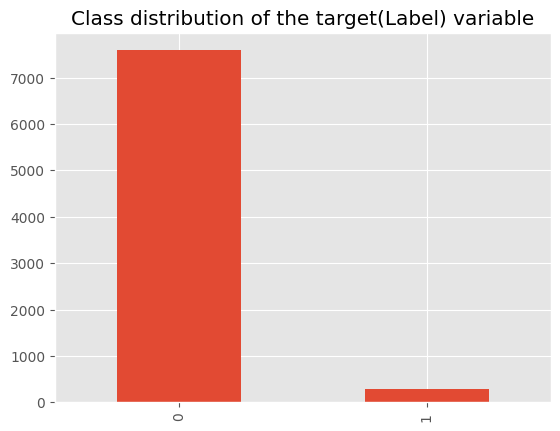

In [25]:
value_counts = df['Label'].value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target(Label) variable")

In [26]:
value_counts

0    7588
1     290
Name: Label, dtype: int64

# ML SIDE

## Classification

In [27]:
#describe the latest df 

df.dtypes

Üye                                int64
Sınav                              int64
Konu                               int64
Sınav Türü                         int64
Doğru Sayısı                       int64
Yanlış Sayısı                      int64
Boş Sayısı                         int64
Puan                               int64
S_Giriş Zamanı            datetime64[ns]
S_Çıkış Zamanı            datetime64[ns]
S_süre                             int64
GirişLog                           int64
Sınıf                              int64
Ders                               int64
Aktif Materyal Sayısı              int64
Toplam Materyal Sayısı             int64
cum_lecture_time                   int64
cum_study_time                     int64
total_study_time                   int64
Label                              int64
Overlap (secs.)                  float64
dtype: object

In [28]:
#change object type to related datatype. Label and Overlap(secs.) are going to be int64

df['Overlap (secs.)'] = df['Overlap (secs.)'].astype('int64')

df.dtypes

Üye                                int64
Sınav                              int64
Konu                               int64
Sınav Türü                         int64
Doğru Sayısı                       int64
Yanlış Sayısı                      int64
Boş Sayısı                         int64
Puan                               int64
S_Giriş Zamanı            datetime64[ns]
S_Çıkış Zamanı            datetime64[ns]
S_süre                             int64
GirişLog                           int64
Sınıf                              int64
Ders                               int64
Aktif Materyal Sayısı              int64
Toplam Materyal Sayısı             int64
cum_lecture_time                   int64
cum_study_time                     int64
total_study_time                   int64
Label                              int64
Overlap (secs.)                    int64
dtype: object

In [29]:
# change the datetime type to unix time

df['S_Giriş Zamanı'] = df['S_Giriş Zamanı'].apply(lambda x: int(x.timestamp()))
df['S_Çıkış Zamanı'] = df['S_Çıkış Zamanı'].apply(lambda x: int(x.timestamp()))

df.dtypes

Üye                       int64
Sınav                     int64
Konu                      int64
Sınav Türü                int64
Doğru Sayısı              int64
Yanlış Sayısı             int64
Boş Sayısı                int64
Puan                      int64
S_Giriş Zamanı            int64
S_Çıkış Zamanı            int64
S_süre                    int64
GirişLog                  int64
Sınıf                     int64
Ders                      int64
Aktif Materyal Sayısı     int64
Toplam Materyal Sayısı    int64
cum_lecture_time          int64
cum_study_time            int64
total_study_time          int64
Label                     int64
Overlap (secs.)           int64
dtype: object

In [30]:
pd.options.display.float_format = '{:.0f}'.format

df.describe().T  # T is for transpose

,count,mean,std,min,25%,50%,75%,max
Üye,7878,1161339761,711401247,2910824,541534265,1169096127,1741043361,2428472503
Sınav,7878,508736635601,284960222327,438484723,263598348446,523324425042,776236916976,994722286690
Konu,7878,8218,2095,3536,8120,8893,9579,10905
Sınav Türü,7878,1,2,1,1,1,1,15
Doğru Sayısı,7878,7,4,0,5,8,10,90
Yanlış Sayısı,7878,1,2,0,0,1,2,42
Boş Sayısı,7878,1,4,0,0,0,0,100
Puan,7878,76,29,0,60,90,100,100
S_Giriş Zamanı,7878,1632012972,680861,1630482682,1631475527,1632084006,1632594517,1633046337
S_Çıkış Zamanı,7878,1632193778,1289985,1630483547,1631534441,1632161656,1632662768,1648291242


c:\Users\melih\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\melih\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


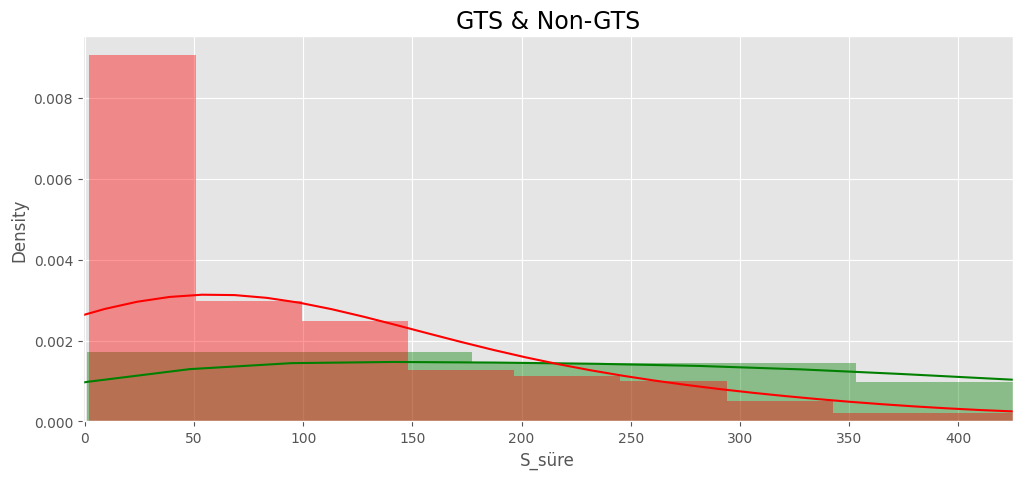

In [31]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df[df['Label'] == 0]["S_süre"], 
             color='g')
sns.distplot(df[df['Label'] == 1]["S_süre"], 
             color='r')
plt.title('GTS & Non-GTS', fontsize=17)
plt.xlim([-1,425])
plt.show()

That shows, students that game the system right skew the data. 

In [32]:
#To clearly see the data of GTS and non-GTS
df_gts = df[df['Label'] == 1]
df_nongts = df[df['Label'] == 0]

print("GTS statistics")
print(df_gts["Puan"].describe())
print("\nNon-GTS statistics")
print(df_nongts["Puan"].describe())

GTS statistics
count   290
mean     80
std      25
min      10
25%      70
50%      90
75%     100
max     100
Name: Puan, dtype: float64

Non-GTS statistics
count   7588
mean      76
std       30
min        0
25%       60
50%       90
75%      100
max      100
Name: Puan, dtype: float64


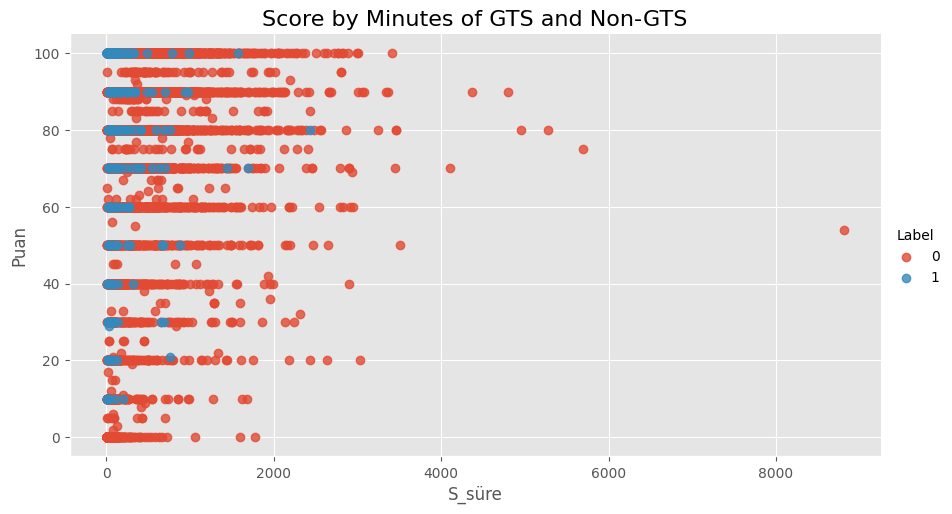

In [33]:
#Looking the Score and time distribuition of GTS.
ax = sns.lmplot(y="Puan", x="S_süre", fit_reg=False,aspect=1.8,
                data=df, hue='Label')
plt.title("Score by Minutes of GTS and Non-GTS",fontsize=16)
plt.show()